In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('diabetes.csv')
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [3]:
df.shape

(768, 9)

In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
# df['Outcome'].values

### ! Do Not forget .values --------- cuz we need to get the values as an array in order to be converted to a FloatTensor

In [6]:
# split
X=df.drop('Outcome',axis=1).values ### independent features
y=df['Outcome'].values ###dependent features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(614, 8) (614,)
(154, 8) (154,)


## We always need to convert the dependent & independent features to floatTensor

In [7]:
#### Libraries From Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

##### Creating Tensors
X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)

y_train=torch.LongTensor(y_train)
y_test=torch.LongTensor(y_test)

In [8]:
df.shape, X_train.shape

((768, 9), torch.Size([614, 8]))

# built Module

In [9]:
# hyperparameters
# we can define them here outside the class ---  or we can do as we do below

class ANN(nn.Module):
    
    def __init__(self, input_feature=8, hidden1=20, hidden2=20, output_feature=2):
        super(ANN, self).__init__()
        
        self.fc1 = nn.Linear(input_feature, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, output_feature)
        
    def forward(self, x):
        out = F.relu(x)
        out = self.fc1(out)
        
        out = F.relu(out)
        out = self.fc2(out)
        
        out = self.out(out)
        return out

#torch.manual_seed(20)
ANN_model = ANN()
ANN_model

ANN(
  (fc1): Linear(in_features=8, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)

# Loss and optimizer

In [10]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ANN_model.parameters(), lr=0.01)


# Training Model

In [11]:
#### Check if loss is getting minimized
epoch = 500
lossess = []
for ix in range(epoch):
    scores_pred = ANN_model(X_train)
    loss = loss_func(scores_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossess.append(loss.item())
    
    if ix % 100 == 0:
        print(f"Loss-error: {loss}")


Loss-error: 3.871251106262207
Loss-error: 0.5409615635871887
Loss-error: 0.4507922828197479
Loss-error: 0.41944384574890137
Loss-error: 0.40023452043533325


Text(0.5, 0, 'epoch')

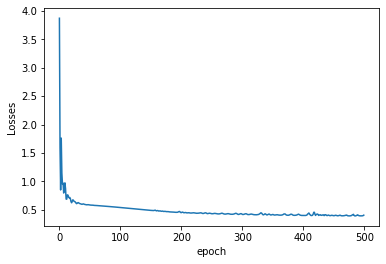

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(epoch), lossess)
plt.ylabel('Losses')
plt.xlabel('epoch')

# Trainig model

In [13]:
X_train.shape, len(X_train)

(torch.Size([614, 8]), 614)

In [14]:
for data in X_test:
    print(data)
    print(ANN_model(data)) #tensor([2.8805, 2.9700], grad_fn=<AddBackward0>) <<<<< we need to protect the grad_fn by
    #saying [ with torch.no_grad()]
    break



tensor([  7.0000, 181.0000,  84.0000,  21.0000, 192.0000,  35.9000,   0.5860,
         51.0000])
tensor([2.7084, 4.1502], grad_fn=<AddBackward0>)


In [15]:
corr_pred = []

with torch.no_grad():
    for data in X_test: # len(154)
        xTest_pred = ANN_model(data)
        corr_pred.append(xTest_pred.argmax().item())
print(corr_pred)

[1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Confusion matrix

In [16]:
from sklearn.metrics import confusion_matrix
acc = confusion_matrix(y_test, corr_pred)
acc

array([[86, 10],
       [28, 30]])

Text(33.0, 0.5, 'Predicted-value')

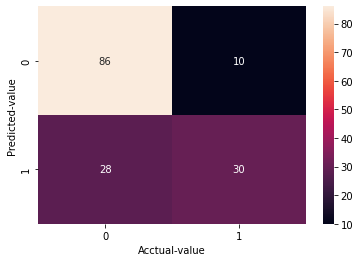

In [17]:
import seaborn as sns
sns.heatmap(acc, annot=True)
plt.xlabel('Acctual-value')
plt.ylabel('Predicted-value')

In [18]:
from sklearn.metrics import accuracy_score
myAccu = accuracy_score(y_test, corr_pred)
myAccu

0.7532467532467533

# Save the model

In [19]:
# The model is doing not bad SO WE CAN SAVE IT
torch.save(ANN_model, 'diabets.pt')

# Load the model

In [20]:
loadedANN_model = torch.load('diabets.pt')
loadedANN_model

ANN(
  (fc1): Linear(in_features=8, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)

# Check if your model predicts well

In [27]:
### let's get one row from our dataframe OR u can copy on row manually
sample1 = df.iloc[0, :-1] # the first row

# convert it to list
sample1 = list(sample1)
sample1

[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0]

In [28]:
# now create a new data from that by changing the values
new_data = [6.0, 130.0, 72.0, 40.0, 0.0, 23.6, 0.627, 40.0]
new_data = torch.FloatTensor(new_data)

with torch.no_grad():
    new_pred = ANN_model(new_data)
    print(new_pred)
    print(new_data.argmax().item())

tensor([ 1.3062, -1.0219])
1


In [23]:
"""
#### Why do we use ReLUs? We use ReLUs for the same reason 
we use any other non-linear activation function: To achieve a non-linear transformation of the data.

Why do we need non-linear transformations? We apply non-linear transformations in the hope 
that the transformed data will be (close to) linear (for regression) or (close to) 
linearly separable (for classification).Drawing a linear function through non-linearly transformed data 
is equivalent to drawing a non-linear function through original data.

Why are ReLUs better than other activation functions? They are simple, fast to compute, 
and don't suffer from vanishing gradients, like sigmoid functions (logistic, tanh, erf, and similar).
The simplicity of implementation makes them suitable for use on GPUs, which are very common today 
due to being optimised for matrix operations (which are also needed for 3D graphics).

"""

"\nWhy do we use ReLUs? We use ReLUs for the same reason \nwe use any other non-linear activation function: To achieve a non-linear transformation of the data.\n\nWhy do we need non-linear transformations? We apply non-linear transformations in the hope \nthat the transformed data will be (close to) linear (for regression) or (close to) \nlinearly separable (for classification).Drawing a linear function through non-linearly transformed data \nis equivalent to drawing a non-linear function through original data.\n\nWhy are ReLUs better than other activation functions? They are simple, fast to compute, \nand don't suffer from vanishing gradients, like sigmoid functions (logistic, tanh, erf, and similar).\nThe simplicity of implementation makes them suitable for use on GPUs, which are very common today \ndue to being optimised for matrix operations (which are also needed for 3D graphics).\n\n"